# 1. Load Library

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.offline as py
import plotly.graph_objs as go
import plotly.io as pio
from plotly.subplots import make_subplots
from cryptocmd import CmcScraper

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

tf.get_logger().setLevel('INFO')
#pio.renderers.default = "svg"

# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

%matplotlib inline

# 2. Analyze data
- scraper BTC data
- draw trend

In [2]:
# scraper BTC data
scraper = CmcScraper("BTC")
data = scraper.get_dataframe()
data.set_index('Date', inplace=True)
data = data.iloc[::-1]
print(data.info())
df = data[(data['Volume']>0)]
df = df.rename(columns = {'Close':'close'})
df = df.rename(columns = {'Open':'open'})
df = df.rename(columns = {'High':'high'})
df = df.rename(columns = {'Low':'low'})
df = df.rename(columns = {'Volume':'volume'})

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3245 entries, 2013-04-28 to 2022-03-16
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        3245 non-null   float64
 1   High        3245 non-null   float64
 2   Low         3245 non-null   float64
 3   Close       3245 non-null   float64
 4   Volume      3245 non-null   float64
 5   Market Cap  3245 non-null   float64
dtypes: float64(6)
memory usage: 177.5 KB
None


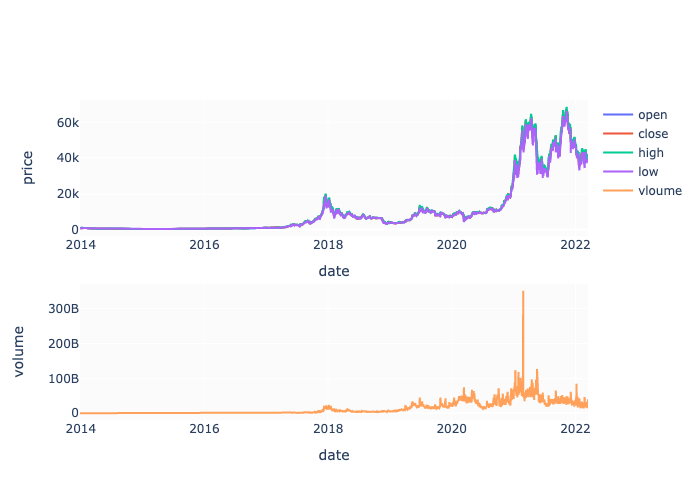

In [3]:
# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Scatter(x=df.index, y=df['open'], name='open'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['close'], name='close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['high'], name='high'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['low'], name='low'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.index, y=df['volume'], name='vloume'), row=2, col=1)

fig.update_xaxes(title="date")
fig.update_yaxes(title="price", row=1, col=1)
fig.update_yaxes(title="volume", row=2, col=1)

fig.show('png')

# 3. Data preprocess
- normalize stock data
- create train, validation and test data sets

In [4]:
# function for min-max normalization of stock
min_max_scaler = sklearn.preprocessing.MinMaxScaler()

def normalize_data(df):
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df.close.values.reshape(-1,1))
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
        
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

df_btc = df.copy()
df_btc.drop(['volume','Market Cap'],1,inplace=True)

cols = list(df_btc.columns.values)
print('df_btc.columns.values = ', cols)

# normalize 
df_btc_norm = df_btc.copy()
df_btc_norm = normalize_data(df_btc_norm)

# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_btc_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

df_btc.columns.values =  ['open', 'high', 'low', 'close']
x_train.shape =  (2386, 19, 4)
y_train.shape =  (2386, 4)
x_valid.shape =  (298, 19, 4)
y_valid.shape =  (298, 4)
x_test.shape =  (298, 19, 4)
y_test.shape =  (298, 4)


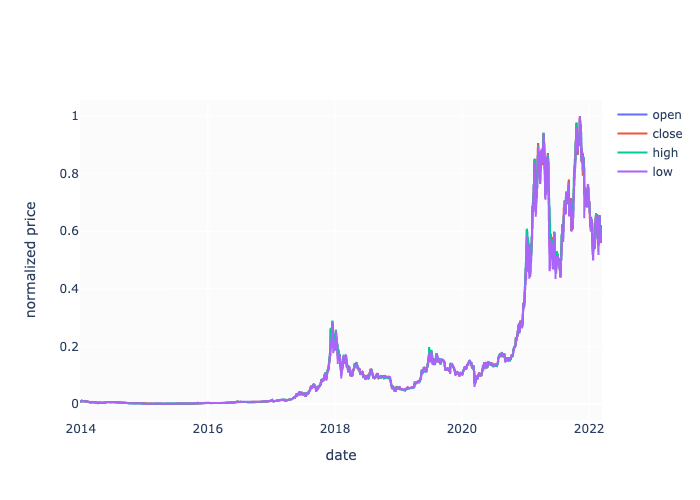

In [5]:
fig = go.Figure(layout=layout)

fig.add_trace(go.Scatter(x=df_btc_norm.index, y=df_btc_norm['open'], name='open'))
fig.add_trace(go.Scatter(x=df_btc_norm.index, y=df_btc_norm['close'], name='close'))
fig.add_trace(go.Scatter(x=df_btc_norm.index, y=df_btc_norm['high'], name='high'))
fig.add_trace(go.Scatter(x=df_btc_norm.index, y=df_btc_norm['low'], name='low'))

fig.update_xaxes(title="date")
fig.update_yaxes(title="normalized price")

fig.show('png')

# 4. Model and validate data <a class="anchor" id="4-bullet"></a> 
- RNNs with basic, LSTM, GRU cells


In [6]:
## Basic Cell RNN in tensorflow
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200
n_outputs = 4
n_layers = 2
learning_rate = 1e-4
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
          for layer in range(n_layers)]

# use Basic LSTM Cell 
# layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections : Slow, no improvement
# layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell : Not fast, no improvement
# layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)

loss_df = pd.DataFrame()

# --- Save model ---
saver = tf.train.Saver()

# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = sess.run(loss, feed_dict={X: x_train, y: y_train}) 
            mse_valid = sess.run(loss, feed_dict={X: x_valid, y: y_valid})  
            loss_output = pd.Series([iteration, mse_train, mse_valid], index=['iter','train_loss','valid_loss'])
            loss_df = loss_df.append(loss_output, ignore_index=True)
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))
            
    saver.save(sess, 'result/rnn4btc', global_step=0)

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.
0.00 epochs: MSE train/valid = 0.006819/0.298889
4.99 epochs: MSE train/valid = 0.000028/0.001533
9.97 epochs: MSE train/valid = 0.000025/0.000815
14.96 epochs: MSE train/valid = 0.000017/0.000892
19.95 epochs: MSE train/valid = 0.000016/0.001125
24.94 epochs: MSE tr

In [7]:
def inverse_normalize_data():   
    global y_train, y_train_pred, y_test, y_test_pred, y_valid, y_valid_pred
    y_train = min_max_scaler.inverse_transform(y_train)
    y_train_pred = min_max_scaler.inverse_transform(y_train_pred)
    y_test = min_max_scaler.inverse_transform(y_test)
    y_test_pred = min_max_scaler.inverse_transform(y_test_pred)
    y_valid = min_max_scaler.inverse_transform(y_valid)
    y_valid_pred = min_max_scaler.inverse_transform(y_valid_pred)
    
inverse_normalize_data()

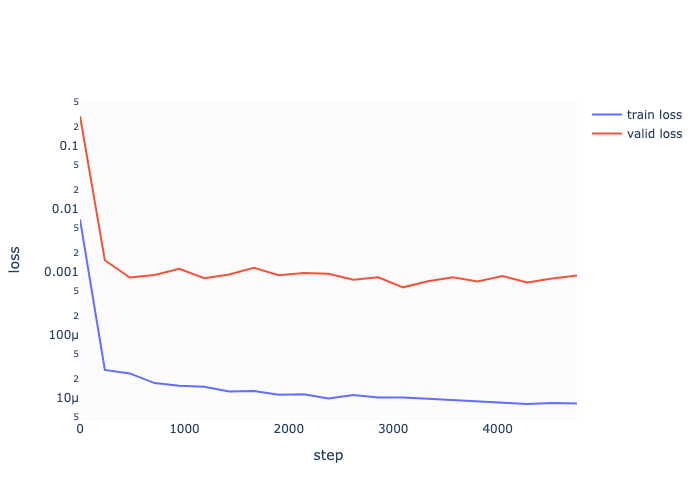

In [8]:
# loss
fig = go.Figure(layout=layout)

fig.add_trace(go.Scatter(x=loss_df['iter'], y=loss_df['train_loss'], name='train loss'))
fig.add_trace(go.Scatter(x=loss_df['iter'], y=loss_df['valid_loss'], name='valid loss'))

fig.update_xaxes(title="step")
fig.update_yaxes(title="loss", type='log')

fig.show('png')

# 5. Predictions <a class="anchor" id="5-bullet"></a> 

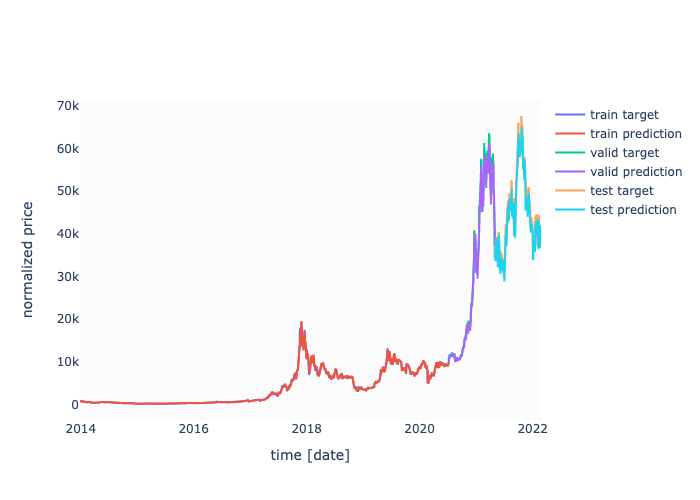

In [26]:
ft = 3 # 0 = 'open', 1 = 'high', 2 = 'low', 3 = 'close'

fig = go.Figure(layout=layout)

fig.add_trace(go.Scatter(x=pd.date_range(start=df_btc_norm.index[0], periods=y_train.shape[0]), y=y_train[:,ft], name='train target'))
fig.add_trace(go.Scatter(x=pd.date_range(start=df_btc_norm.index[0], periods=y_train.shape[0]), y=y_train_pred[:,ft], name='train prediction'))
fig.add_trace(go.Scatter(x=pd.date_range(start=(df_btc_norm.index[0]+datetime.timedelta(days=y_train.shape[0])), periods=y_valid.shape[0]), y=y_valid[:,ft], name='valid target'))
fig.add_trace(go.Scatter(x=pd.date_range(start=(df_btc_norm.index[0]+datetime.timedelta(days=y_train.shape[0])), periods=y_valid.shape[0]), y=y_valid_pred[:,ft], name='valid prediction'))
fig.add_trace(go.Scatter(x=pd.date_range(start=(df_btc_norm.index[0]+datetime.timedelta(days=y_train.shape[0]+y_valid.shape[0])), periods=y_test.shape[0]), y=y_test[:,ft], name='test target'))
fig.add_trace(go.Scatter(x=pd.date_range(start=(df_btc_norm.index[0]+datetime.timedelta(days=y_train.shape[0]+y_valid.shape[0])), periods=y_test.shape[0]), y=y_test_pred[:,ft], name='test prediction'))

# fig.add_trace(go.Scatter(x=np.arange(y_train.shape[0]), y=y_train[:,ft], name='train target'))
# fig.add_trace(go.Scatter(x=np.arange(y_train.shape[0]), y=y_train_pred[:,ft], name='train prediction'))
# fig.add_trace(go.Scatter(x=np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y=y_valid[:,ft], name='valid target'))
# fig.add_trace(go.Scatter(x=np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y=y_valid_pred[:,ft], name='valid prediction'))
# fig.add_trace(go.Scatter(x=np.arange(y_train.shape[0]+y_valid.shape[0], y_train.shape[0]+y_test.shape[0]+y_test.shape[0]), y=y_test[:,ft], name='test target'))
# fig.add_trace(go.Scatter(x=np.arange(y_train.shape[0]+y_valid.shape[0], y_train.shape[0]+y_test.shape[0]+y_test.shape[0]), y=y_test_pred[:,ft], name='test prediction'))

fig.update_xaxes(title="time [date]")
fig.update_yaxes(title="normalized price")

fig.show('png')

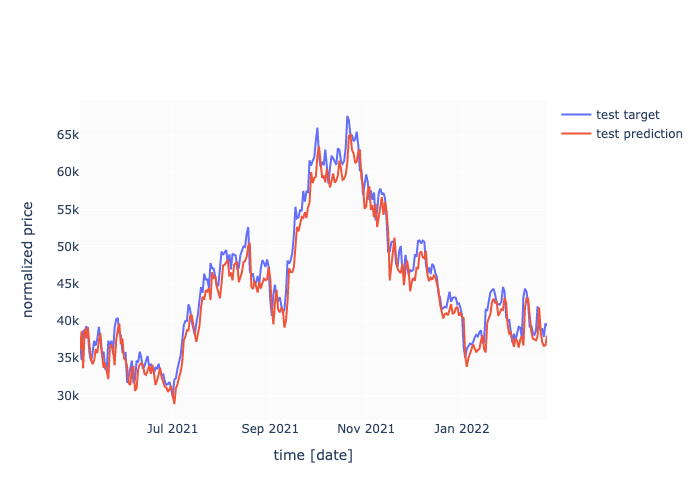

correct sign prediction for close - open price for train/valid/test: 0.67/0.48/0.52


In [23]:
fig = go.Figure(layout=layout)

fig.add_trace(go.Scatter(x=pd.date_range(start=(df_btc_norm.index[0]+datetime.timedelta(days=y_train.shape[0]+y_valid.shape[0])), periods=y_test.shape[0]), y=y_test[:,ft], name='test target'))
fig.add_trace(go.Scatter(x=pd.date_range(start=(df_btc_norm.index[0]+datetime.timedelta(days=y_train.shape[0]+y_valid.shape[0])), periods=y_test.shape[0]), y=y_test_pred[:,ft], name='test prediction'))
# fig.add_trace(go.Scatter(x=np.arange(y_train.shape[0]+y_valid.shape[0], y_train.shape[0]+y_test.shape[0]+y_test.shape[0]), y=y_test[:,ft], name='test target'))
# fig.add_trace(go.Scatter(x=np.arange(y_train.shape[0]+y_valid.shape[0], y_train.shape[0]+y_test.shape[0]+y_test.shape[0]), y=y_test_pred[:,ft], name='test prediction'))

fig.update_xaxes(title="time [date]")
fig.update_yaxes(title="normalized price")

fig.show('png')

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))

## Analyse the result
- check whether it's just a shift on date

mean = -2.915000, std = 3.842927


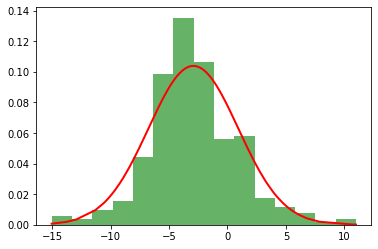

In [24]:
from scipy.stats import norm, kurtosis, skew

y_test_relative_diff = (y_test_pred[:,ft]-y_test[:,ft])/y_test[:,ft]*100

plt.hist(y_test_relative_diff, bins=15, density=True, alpha=0.6, color='g')

# Plot the PDF.
mu, std = norm.fit(y_test_relative_diff)
x = np.sort(y_test_relative_diff)
y = norm.pdf(x, mu, std)
plt.plot(x, y, linewidth=2, color='red')
print("mean = %f, std = %f" % (mu, std))

mean = -2.964854, std = 1.281509


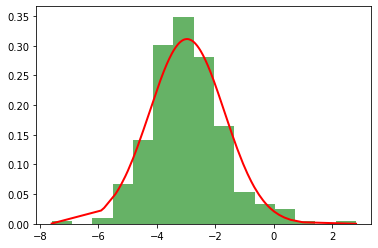

In [25]:
from scipy.ndimage.interpolation import shift

y_test_pred_shift = y_test_pred[:,ft].copy()
y_test_pred_shift = shift(y_test_pred_shift,-1,cval=np.NaN)
y_test_relative_diff = (y_test_pred_shift-y_test[:,ft])/y_test[:,ft]*100
y_test_relative_diff = y_test_relative_diff[np.logical_not(np.isnan(y_test_relative_diff))]

plt.hist(y_test_relative_diff, bins=15, density=True, alpha=0.6, color='g')

# Plot the PDF.
mu, std = norm.fit(y_test_relative_diff)
x = np.sort(y_test_relative_diff)
y = norm.pdf(x, mu, std)
plt.plot(x, y, linewidth=2, color='red')
print("mean = %f, std = %f" % (mu, std))

## Conclusion
- A shift on date could achieve smaller std, which means that actually the prediction is just a shift on date